1. Importaciones

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import warnings
import re
warnings.filterwarnings('ignore')


#### 1.0 Funciones útiles

In [2]:
def showPie(columna):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > 15:
    count_values = count_values.iloc[0:15]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15, pref="", title=""):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  count_values.index = count_values.index.astype('str') + pref
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})
  fig = px.pie(datos, values='ocurrencia', names='valor', title=title)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()
  
def nulos_filas(data):
    return pd.DataFrame(data.isna().sum(axis=1).value_counts().reset_index().values, columns=['cant_col_nulas', 'cantidad'])

from IPython.display import display, Markdown

def resumen(data, nombre_tabla="Resumen Tabla"):
    filas, columnas = data.shape
    valores = filas * columnas
    nulos, duplicados =  data.isna().values.sum(), data.duplicated().sum()
    tasa_nulos, tasa_duplicados = nulos / valores, duplicados / valores

    salida = f'''<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>{nombre_tabla}</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> {filas} </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> {columnas} </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> {valores} </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> {nulos} </td><td style='text-align: right'> {round(100*tasa_nulos, 2)} % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> {duplicados} </td><td style='text-align: right'> {round(100*tasa_duplicados, 2)} %</td><tr/>
    </tbody>
    </table>'''

    display(Markdown(salida))

  

## 1.1 Extracción, Transformación y Carga de Datos (ETL)

### 1.1.1 Extracción

In [3]:

# Datos Homicidios Hechos
data_hm = pd.read_excel('data/homicidios.xlsx', sheet_name='HECHOS')

# Datos Homicidios Victimas
data_vm = pd.read_excel('data/homicidios.xlsx', sheet_name='VICTIMAS')
# Datos Lesiones Hechos
# data_hl = pd.read_excel('data/lesiones.xlsx', sheet_name='HECHOS')
data_hl = pd.read_csv('data/generated/data_hl.csv', usecols=lambda x: x != 0)
# Datos Lesiones Victimas
# data_vl = pd.read_excel('data/lesiones.xlsx', sheet_name='VICTIMAS')
data_vl = pd.read_csv('data/generated/data_vl.csv', usecols=lambda x: x != 0)

# https://www.indec.gob.ar/ftp/cuadros/poblacion/cnphv2022_resultados_provisionales.pdf Página 8
data_pob_comunas = pd.read_excel('data/cnphv2022_resultados_provisionales.xlsx', sheet_name='Table 2').query("Comuna != 'Total'").iloc[:,[3]]

# Barrios
df_barrios = pd.read_excel('data/barrios.xlsx')
# Comunas
df_comunas = pd.read_excel('data/comunas.xlsx')

In [4]:
data_hm

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2021-0093,1,2021-12-13,2021,12,13,17:10:00,17,AV. RIESTRA Y MOM,AVENIDA,...,NaN,MOM,RIESTRA AV. y MOM,7,Point (102728.60090138 98186.24929177),-58.43353773,-34.64561636,MOTO-AUTO,MOTO,AUTO
692,2021-0094,1,2021-12-20,2021,12,20,01:10:00,1,AU DELLEPIANE Y LACARRA,AUTOPISTA,...,NaN,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,Point (99624.29795829 97569.69801131),-58.46739825,-34.65117757,MOTO-AUTO,MOTO,AUTO
693,2021-0095,1,2021-12-30,2021,12,30,00:43:00,0,AV. GAONA Y TERRADA,AVENIDA,...,NaN,TERRADA,GAONA AV. y TERRADA,11,Point (99116.45492358 101045.23284826),-58.47293407,-34.61984745,MOTO-CARGAS,MOTO,CARGAS
694,2021-0096,1,2021-12-15,2021,12,15,10:30:00,10,AV. EVA PERON 4071,AVENIDA,...,4071.0,NaN,"PERON, EVA AV. 4071",9,Point (99324.54463985 97676.26932409),-58.47066794,-34.65021673,AUTO-CARGAS,AUTO,CARGAS


In [5]:
# data_hl.to_csv('data/generated/data_hl.csv')
# data_vl.to_csv('data/generated/data_vl.csv')

In [6]:
df_barrios = pd.read_excel('data/barrios.xlsx')
len(df_barrios.dropna().BARRIO.unique())

df_comunas = pd.read_excel('data/comunas.xlsx')

In [7]:
# from shapely.geometry import Polygon, Multipolygon
import geopandas

# shapely_polygon = Polygon(df_barrios.WKT[0])

# geopandas.GeoSeries([multipolygon]).__geo_interface__

# features = [{'type': 'Feature', 'properties': {}, 'geometry': shapely.geometry.mapping(shapelyObject)}]

In [8]:
from shapely.geometry import Polygon, MultiPolygon
import ast

# Convertir la cadena a una estructura de datos que pueda ser procesada
coordinates = ast.literal_eval("[[[-58.4528200492791, -34.5959886570639],[-58.453655193137, -34.5965557163041],[-58.4537674321647,-34.5966342484151]]]")

# Crear los polígonos individuales a partir de las coordenadas
polygons = [Polygon(coords) for coords in coordinates]

# Crear el multipolígono
multipolygon = MultiPolygon(polygons)

# Imprimir el multipolígono
# print(multipolygon)
# geopandas.GeoSeries([multipolygon]).__geo_interface__

In [9]:
from shapely.geometry import Polygon
import ast

# Convertir la cadena a una estructura de datos que pueda ser procesada
coordinates = ast.literal_eval("[[-58.4528200492791, -34.5959886570639],[-58.453655193137, -34.5965557163041],[-58.4537674321647,-34.5966342484151]]")

# Crear el polígono
polygon = Polygon(coordinates)

# Imprimir el polígono
print(polygon)


POLYGON ((-58.4528200492791 -34.5959886570639, -58.453655193137 -34.5965557163041, -58.4537674321647 -34.5966342484151, -58.4528200492791 -34.5959886570639))


(array([  8.,  32., 181., 130.,  91.,  66.,  48.,  55.,  41.,  12.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <BarContainer object of 10 artists>)

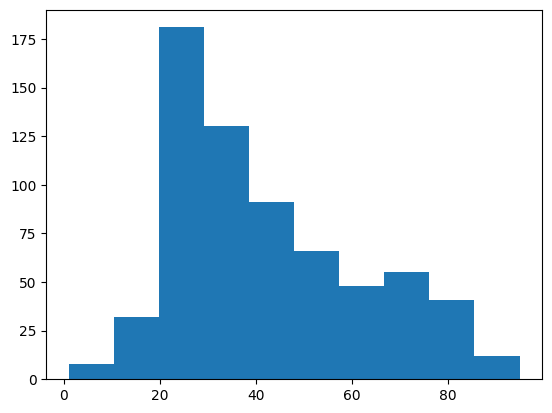

In [10]:
plt.hist(pd.merge(data_hm, data_vm, how='left', left_on='ID', right_on='ID_hecho').query("EDAD != 'SD'")['EDAD'].astype(int))

In [11]:
import pandas as pd

# Perform the left join
merged_df = pd.merge(data_hm, data_vm, how='left', left_on='ID', right_on='ID_hecho')

# Identify duplicates from data_hm in the resulting DataFrame
duplicates_in_merged_df = merged_df[merged_df.duplicated(subset='ID', keep=False)]

# Print or inspect the duplicates
print("Duplicates from data_hm in the resulting DataFrame:")
print(duplicates_in_merged_df)

Duplicates from data_hm in the resulting DataFrame:
            ID  N_VICTIMAS    FECHA_x  AAAA_x  MM_x  DD_x      HORA  HH  \
29   2016-0041           2 2016-03-29    2016     3    29  11:00:00  11   
30   2016-0041           2 2016-03-29    2016     3    29  11:00:00  11   
98   2016-0126           2 2016-09-18    2016     9    18  22:45:00  22   
99   2016-0126           2 2016-09-18    2016     9    18  22:45:00  22   
163  2017-0026           2 2017-02-26    2017     2    26  05:15:00   5   
164  2017-0026           2 2017-02-26    2017     2    26  05:15:00   5   
173  2017-0035           3 2017-03-23    2017     3    23  05:00:00   5   
174  2017-0035           3 2017-03-23    2017     3    23  05:00:00   5   
175  2017-0035           3 2017-03-23    2017     3    23  05:00:00   5   
176  2017-0036           2 2017-03-29    2017     3    29  18:00:00  18   
177  2017-0036           2 2017-03-29    2017     3    29  18:00:00  18   
186  2017-0050           2 2017-04-28    2017   

In [12]:
data_hm

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
691,2021-0093,1,2021-12-13,2021,12,13,17:10:00,17,AV. RIESTRA Y MOM,AVENIDA,...,NaN,MOM,RIESTRA AV. y MOM,7,Point (102728.60090138 98186.24929177),-58.43353773,-34.64561636,MOTO-AUTO,MOTO,AUTO
692,2021-0094,1,2021-12-20,2021,12,20,01:10:00,1,AU DELLEPIANE Y LACARRA,AUTOPISTA,...,NaN,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,Point (99624.29795829 97569.69801131),-58.46739825,-34.65117757,MOTO-AUTO,MOTO,AUTO
693,2021-0095,1,2021-12-30,2021,12,30,00:43:00,0,AV. GAONA Y TERRADA,AVENIDA,...,NaN,TERRADA,GAONA AV. y TERRADA,11,Point (99116.45492358 101045.23284826),-58.47293407,-34.61984745,MOTO-CARGAS,MOTO,CARGAS
694,2021-0096,1,2021-12-15,2021,12,15,10:30:00,10,AV. EVA PERON 4071,AVENIDA,...,4071.0,NaN,"PERON, EVA AV. 4071",9,Point (99324.54463985 97676.26932409),-58.47066794,-34.65021673,AUTO-CARGAS,AUTO,CARGAS


In [13]:
# %% pip install shapely
# %%pip install geopandas

In [14]:
df_barrios.WKT[0]

'MULTIPOLYGON (((-58.4528200492791 -34.5959886570639,-58.453655193137 -34.5965557163041,-58.4537674321647 -34.5966342484151,-58.4538163134148 -34.5966684788922,-58.4547947928051 -34.5973527273643,-58.4554840815947 -34.5978347610252,-58.4559204833295 -34.5976953435828,-58.4560093721285 -34.5976669530232,-58.4560576047802 -34.5976515472868,-58.4562363723257 -34.5975900748435,-58.4564940053845 -34.5975015637739,-58.4570733158433 -34.5973024999733,-58.4576142986162 -34.597116530699,-58.4578298572665 -34.5970394940223,-58.4579314199407 -34.5970031094654,-58.4579383597537 -34.5970006235554,-58.457939151188 -34.5970004324802,-58.4580314840712 -34.5969781271248,-58.4582467474022 -34.5969261254882,-58.4592081863103 -34.5966936826245,-58.4592753814056 -34.5966774864904,-58.4607717313584 -34.5965908256843,-58.461008489241 -34.5965771669178,-58.461500184562 -34.5965469590602,-58.4615048306101 -34.5965466787569,-58.4623220712384 -34.5965110490604,-58.4624802220071 -34.5965042183086,-58.462520654130

### 1.1.2 Transformación

### 1.1.2.1 Dataset Homicidios

#### 1.1.2.1.0 Primer Vistazo al Set de Datos

In [15]:
resumen(data_hm)

<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>Resumen Tabla</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> 696 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> 21 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> 14616 </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> 747 </td><td style='text-align: right'> 5.11 % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> 0 </td><td style='text-align: right'> 0.0 %</td><tr/>
    </tbody>
    </table>

#### 1.1.2.1.1 Análisis de Nulos

##### a. Por filas

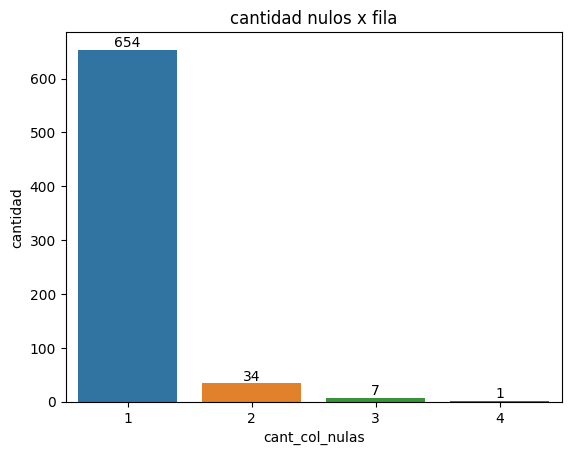

In [16]:
ax = sns.barplot(x=nulos_filas(data_hm).cant_col_nulas, y=nulos_filas(data_hm).cantidad)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("cantidad nulos x fila")
plt.show()

Significa que hay 654 filas que tienen una columna nula, 34 filas con 2 columnas nulas. Este análisis sirve para detectar filas completamente nulas, por ejemplo.

Ahora analizamos los valores nulos por columna.

##### b. Por columnas

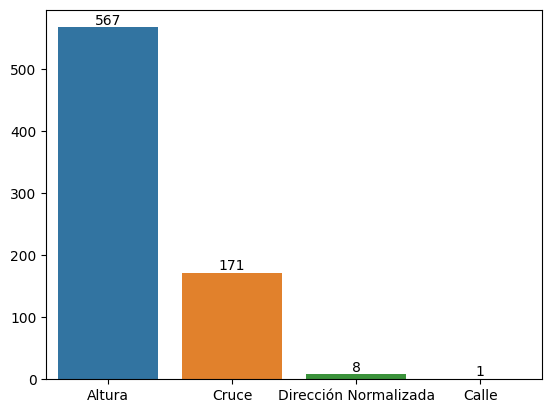

In [17]:
nulos_columnas = data_hm.isna().sum()[data_hm.isna().sum() > 0].sort_values(ascending=False)
ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [18]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo

print(f"Cantidad filas: {data_hm.shape[0]}")
print(f"Cantidad filas al menos un nulo: {len(data_hm.isna().T.sum()>0)}")

Cantidad filas: 696
Cantidad filas al menos un nulo: 696


Vemos que todas las filas tienen al menos un valor nulo.

##### c. Nulos Reales y Estructurales

Después de hacer un oversight sobre el dataset, vemos que Altura y Cruce son excluyentes, cuando está definida la altura es porque es sobre una calle propia y en caso contrario es una esquina. Por lo tanto, vamos a excluirlas del análisis de nulos.

In [19]:
# La columna altura se llena con ESQ cuando es esquina
data_hm.Altura = data_hm.Altura.fillna('ESQ')

# Se limpia el valor altura cuando lo toma como decimal
data_hm.Altura = data_hm.Altura.apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))

In [20]:
# La columna Cruce se llena con 'NA': 'No Aplica'
data_hm.Cruce = data_hm.Cruce.fillna('NA')

Ya limpio de los nulos estructurales o sea, definidos por la naturaleza de los campos, vamos a los nulos reales.

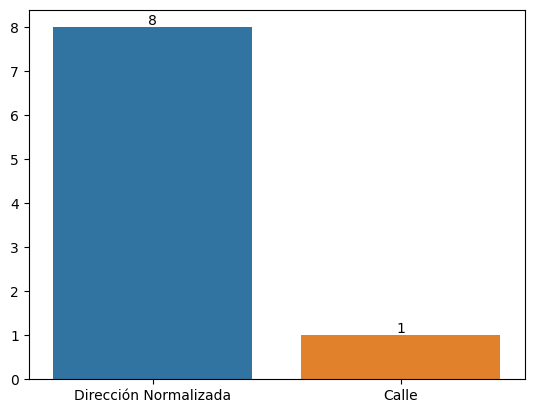

In [21]:
nulos_columnas = data_hm.isna().sum()[data_hm.isna().sum() > 0].sort_values(ascending=False)

if len(nulos_columnas) > 0:
    ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

Columna ```Dirección Normalizada```

In [22]:
data_hm[data_hm.isna().loc[:, 'Dirección Normalizada']].head(3)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
38,2016-0052,1,2016-04-20,2016,4,20,20:00:00,20,AUTOPISTA LUGONES PK 10000,AUTOPISTA,...,ESQ,NA,NaN,13,Point (. .),.,.,MOTO-SD,MOTO,SD
106,2016-0136,1,2016-10-25,2016,10,25,00:00:00,0,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,...,ESQ,NA,NaN,4,Point (. .),.,.,MOTO-CARGAS,MOTO,CARGAS
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,ESQ,NA,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


Columna ```Calle```

In [23]:
data_hm[data_hm.isna().loc[:, 'Calle']]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,ESQ,NA,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


Al no tener información suficiente podemos excluir el registro ```2016-0151```. Falleció un peatón, sé a qué fecha-hora, pero no sé en dónde, ni cómo.

In [24]:
data_hm = data_hm.drop(data_hm[data_hm['ID']=='2016-0151'].index)

Rellenamos la información faltante en la columna ```Dirección Normalizada``` con los valores de ```LUGAR_DEL_HECHO```

In [25]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]
for i in nulos:
    data_hm['Dirección Normalizada'].iloc[i] = data_hm['LUGAR_DEL_HECHO'].iloc[i]

Según lo visto, cuando la direcciòn normalizada es nula es porque ocurre en autopista, sólo un caso en el que es calle porque es un registro con valores nulos o sin datos, del que se puede prescindir.

Vemos que hay otros valores nulos encubiertos, como ```'.'``` en las coordenadas GPS, o ```Point (. .)```, en las otras coordenads espaciales, o ```SD``` en otros campos. Inclusive ```0``` en la columna ```COMUNA```, siendo 15 comunas a partir de la 1.

In [26]:
data_hm['geo_info'] = True

In [27]:
# data_['pos x'].apply(lambda x: float(x) if x.lstrip().isnumeric() else None)
data_hm['pos x'] = data_hm['pos x'].apply(lambda x: 0 if x == '.' else float(x))
data_hm['pos y'] = data_hm['pos y'].apply(lambda x: 0 if x == '.' else float(x))


In [28]:
for i in data_hm.index:
    if data_hm.loc[i, 'pos x'] == 0:
        data_hm.loc[i, 'geo_info'] = False
    if data_hm.loc[i, 'pos y'] == 0:
        data_hm.loc[i, 'geo_info'] = False


In [29]:
data_hm['geo_info'].value_counts()

geo_info
True     684
False     11
Name: count, dtype: int64

In [30]:
# data_['pos x'].fillna(data_['pos x'].mean(), inplace=True)
# data_['pos y'].fillna(data_['pos y'].mean(), inplace=True)
# data_hm[data_hm['pos x'].isna()]
# data_hm.query("PARTICIPANTES == 'SD-SD'")
data_hm.query("COMUNA == 0")
# data_hm.COMUNA.isnull().sum()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info
139,2016-0174,1,2016-12-27,2016,12,27,00:00:00,0,AUTOPISTA 25 DE MAYO,AUTOPISTA,...,NA,AUTOPISTA 25 DE MAYO,0,Point (. .),0.0,0.0,SD-SD,SD,SD,False


Eliminada por falta de datos

In [31]:
data_hm.drop(139, axis =0, inplace = True)

In [32]:
contar_nulos(data_hm)

ID                       0
N_VICTIMAS               0
FECHA                    0
AAAA                     0
MM                       0
DD                       0
HORA                     0
HH                       0
LUGAR_DEL_HECHO          0
TIPO_DE_CALLE            0
Calle                    0
Altura                   0
Cruce                    0
Dirección Normalizada    0
COMUNA                   0
XY (CABA)                0
pos x                    0
pos y                    0
PARTICIPANTES            0
VICTIMA                  0
ACUSADO                  0
geo_info                 0
dtype: int64

Podemos prescindir de las columnas ```AAAA, MM, DD, HH, XY (CABA)``` ya que duplican información

In [33]:
data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

In [34]:
data_hm.COMUNA = data_hm.COMUNA.astype(str)

In [35]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info
518,2019-0103,1,2019-12-18,SD,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,"PAZ, GRAL. AV.",ESQ,GRIVEO,"PAZ, GRAL. AV. y GRIVEO",11,-58.521694,-34.594716,MOTO-MOTO,MOTO,MOTO,True


In [36]:
data_hm["HORA"] = data_hm["HORA"].replace('SD', '00:00:00')

In [37]:
data_hm["HORA"] = data_hm["HORA"].astype(str)

In [38]:
data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)


In [39]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info


In [40]:
# data_hm['COMUNA'] = data_hm['COMUNA'].replace('0', np.nan)

data_hm.COMUNA.isna().sum()

0

In [41]:
# data_hm['FECHA_HORA'] = pd.to_datetime(data_hm['FECHA']) + data_hm['HORA'].apply(lambda x: pd.Timedelta(x))

In [42]:
data_hm['HORA'] = data_hm['HORA'].astype(str)

In [43]:
import re

pattern = r'[:\s;-]'

data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: re.split(pattern, x))

# data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: x.split(' ').split('-').split(':'))


In [44]:
data_hm['FECHA_HORA']

0      [2016, 01, 01, 04, 00, 00]
1      [2016, 01, 02, 01, 15, 00]
2      [2016, 01, 03, 07, 00, 00]
3      [2016, 01, 10, 00, 00, 00]
4      [2016, 01, 21, 05, 20, 00]
                  ...            
691    [2021, 12, 13, 17, 10, 00]
692    [2021, 12, 20, 01, 10, 00]
693    [2021, 12, 30, 00, 43, 00]
694    [2021, 12, 15, 10, 30, 00]
695    [2021, 11, 18, 06, 10, 00]
Name: FECHA_HORA, Length: 694, dtype: object

In [45]:
# for i in data_hm['FECHA_HORA']:
#     list(map(int, i))

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(lambda x: list(map(int, x)))

In [46]:
from datetime import datetime
# # data_hm['FECHA_HORA'].apply(lambda t: datetime(*map(int,t)))

# for i, f in enumerate(data_hm['FECHA_HORA']):
#     for n in f:
#         n = int(n)
#     data_hm['FECHA_HORA'].loc[i] = f

def to_date(t):
    return datetime(* t)

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(to_date)

In [47]:
data_hm['FECHA_HORA'] 

0     2016-01-01 04:00:00
1     2016-01-02 01:15:00
2     2016-01-03 07:00:00
3     2016-01-10 00:00:00
4     2016-01-21 05:20:00
              ...        
691   2021-12-13 17:10:00
692   2021-12-20 01:10:00
693   2021-12-30 00:43:00
694   2021-12-15 10:30:00
695   2021-11-18 06:10:00
Name: FECHA_HORA, Length: 694, dtype: datetime64[ns]

In [48]:
# def to_timestamp(x):
#     year, month, day, hour, minute, second = map(int, x)
#     return datetime(year, month, day, hour, minute, second)

In [49]:
# to_timestamp(data_hm['FECHA_HORA'][0])

In [50]:
# data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)

In [51]:
# for i in data_hm['FECHA_HORA'].index:
#     try:
#         to_timestamp(data_hm['FECHA_HORA'].loc[i])
#     except:
#         print(data_hm[['FECHA', 'HORA']].loc[i])


In [52]:
# date_time_list = [int(x) for x in data_hm['FECHA_HORA'][0]]
# date_time_list

In [53]:
# year, month, day, hour, minutes, seconds 

In [54]:
data_hm.COMUNA.value_counts()

COMUNA
1     90
4     76
9     73
8     65
7     60
3     45
15    44
13    40
12    37
14    35
11    32
10    29
2     25
5     22
6     21
Name: count, dtype: int64

In [55]:
type(data_hm['PARTICIPANTES'][0])

str

In [56]:
# import json
coordinates = [data_hm['pos x'].sample(1).values[0], data_hm['pos y'].sample(2).values[0]]

# Create a GeoJSON point feature
point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)}
} for x, y, p, d in zip(data_hm['pos x'].values, data_hm['pos y'].values, data_hm['PARTICIPANTES'].values, data_hm['Dirección Normalizada'].values)]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

# pd.DataFrame(point_geojson)

json_file_path = "data/generated/output.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

In [57]:
data_hm[data_hm['geo_info']]['pos x'].mean()

-58.441545233561044

In [58]:
data_hm[data_hm['geo_info']]['pos y'].mean()

-34.61963157034327

In [59]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]



In [60]:
# data_.iloc[data_['Dirección Normalizada'].isna(), 13] = data_.iloc[data_['Dirección Normalizada'].isna(), 8].values

In [61]:

data = data_hm.set_index(data_hm.ID)
data.drop('ID', axis=1, inplace=True,errors='ignore')
data

,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info,FECHA_HORA
ID,,,,,,,,,,,,,,,,,
2016-0001,1,2016-01-01,04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00
2016-0002,1,2016-01-02,01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00
2016-0003,1,2016-01-03,07:00:00,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00
2016-0004,1,2016-01-10,00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00
2016-0005,1,2016-01-21,05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,2021-12-13,17:10:00,AV. RIESTRA Y MOM,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00
2021-0094,1,2021-12-20,01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00
2021-0095,1,2021-12-30,00:43:00,AV. GAONA Y TERRADA,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00


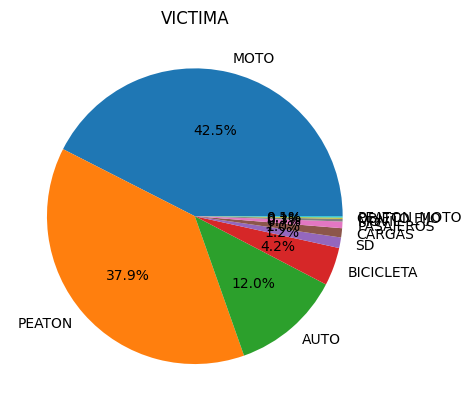

In [62]:
showPie(data['VICTIMA'])

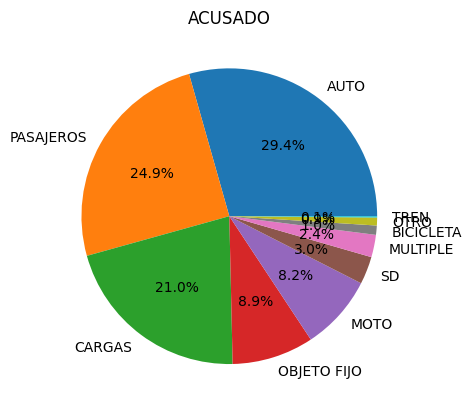

In [63]:
showPie(data['ACUSADO'])

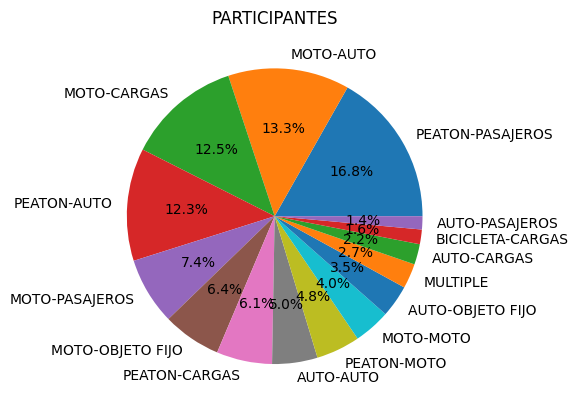

In [64]:
showPie(data['PARTICIPANTES'])

In [65]:
data.describe()

,N_VICTIMAS,FECHA,pos x,pos y,FECHA_HORA
count,694.000000,694,694.000000,694.000000,694
mean,1.030259,2018-09-16 01:52:02.766570496,-57.599448,-34.120790,2018-09-16 13:52:40.442363136
min,1.000000,2016-01-01 00:00:00,-58.529942,-34.705250,2016-01-01 04:00:00
25%,1.000000,2017-04-04 18:00:00,-58.475701,-34.643537,2017-04-05 13:41:15
50%,1.000000,2018-07-14 12:00:00,-58.443654,-34.622535,2018-07-14 18:47:00
75%,1.000000,2020-01-04 18:00:00,-58.399650,-34.595143,2020-01-05 11:40:00
max,3.000000,2021-12-30 00:00:00,0.000000,0.000000,2021-12-30 00:43:00
std,0.179644,NaN,6.969679,4.128761,NaN


In [66]:
# data['ACUSADO'].corr(data['VICTIMA'])

In [67]:


df_comunas['barrios'] = df_comunas.BARRIOS.apply(lambda x: x.split(' - '))

# pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas[['ID', 'COMUNAS']], left_on='comuna_id', right_on='ID')
df_comunas.set_index('COMUNAS', drop=True, inplace=True)
df_comunas.drop('ID', axis = 1, inplace=True, errors='ignore')
df_comunas.sort_index()

,OBJETO,BARRIOS,PERIMETRO,AREA,barrios
COMUNAS,,,,,
1,LIMITE COMUNAL,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,"[CONSTITUCION, MONTSERRAT, PUERTO MADERO, RETI..."
2,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
3,LIMITE COMUNAL,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,"[BALVANERA, SAN CRISTOBAL]"
4,LIMITE COMUNAL,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,35423.282799,2.168464e+07,"[BARRACAS, BOCA, NUEVA POMPEYA, PARQUE PATRICIOS]"
5,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
6,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
7,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
8,LIMITE COMUNAL,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,20935.012513,2.221690e+07,"[VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI]"
9,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"


In [68]:
pd.merge(pd.DataFrame(df_comunas.barrios.explode()).reset_index(names='comuna_id'), df_comunas, left_on='comuna_id', right_on='COMUNAS')

,comuna_id,barrios_x,OBJETO,BARRIOS,PERIMETRO,AREA,barrios_y
0,2,RECOLETA,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
1,5,ALMAGRO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
2,5,BOEDO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
3,6,CABALLITO,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
4,7,FLORES,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
5,7,PARQUE CHACABUCO,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
6,9,LINIERS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
7,9,MATADEROS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
8,9,PARQUE AVELLANEDA,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
9,10,FLORESTA,LIMITE COMUNAL,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"[FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS..."


In [69]:
barrio_comuna = pd.DataFrame(df_comunas.barrios.explode())

In [70]:
barrio_comuna

,barrios
COMUNAS,
2,RECOLETA
5,ALMAGRO
5,BOEDO
6,CABALLITO
7,FLORES
7,PARQUE CHACABUCO
9,LINIERS
9,MATADEROS
9,PARQUE AVELLANEDA


In [71]:
# barrios.BARRIO.

In [72]:
# import pandas as pd
# import researchpy as rp

# # Assuming df is your DataFrame containing the categorical variables
# # Let's say 'var1' and 'var2' are the columns representing the categorical variables

# data = data.reset_index()

# # Create a contingency table (cross-tabulation)
# contingency_table = pd.crosstab(data['ACUSADO'], data['VICTIMA'])

# # Calculate Cramér's V
# cramers_v_result = rp.crosstab(data['ACUSADO'], data['VICTIMA'], 
#                                 prop= 'cell', 
#                                 test= 'chi-square', 
#                                 expected_freqs= True, 
                                
#                                 correction= False)['results']

# cramers_v = cramers_v_result.loc[2, 'results']

# print("Cramér's V:", cramers_v)


In [73]:
# %pip install ipywidgets

In [74]:
pd.crosstab(data_hm['VICTIMA'], data_hm['ACUSADO'])


ACUSADO,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
VICTIMA,,,,,,,,,,
AUTO,31,0,14,0,3,21,1,9,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,83,2,78,25,8,40,4,46,9,0
MOVIL,0,0,1,0,0,0,0,1,0,0
OBJETO FIJO,1,0,0,0,0,0,0,0,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,77,5,38,30,5,0,0,105,3,0
PEATON_MOTO,0,0,0,1,0,0,0,0,0,0


In [75]:
data_hm['ES_CRUCE'] = data_hm['Cruce'] != 'NA'

In [76]:
data_hm['ES_CRUCE'].value_counts()

ES_CRUCE
True     525
False    169
Name: count, dtype: int64

In [77]:
data_hm['Cruce'].fillna('NA', inplace=True)

In [78]:
pd.crosstab(data_hm['PARTICIPANTES'], data_hm['ES_CRUCE']).sum()

ES_CRUCE
False    169
True     525
dtype: int64

In [79]:
data_hm = data_hm.set_index(data_hm['ID']).drop(['ID','FECHA','HORA','LUGAR_DEL_HECHO'], axis=1)

In [80]:
data_hm.columns = [c.lower().replace(' ','_') for c in data_hm.columns]

# plt.plot(data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum())

In [81]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


In [82]:
data_hm['comuna'][data_hm['comuna'].isnull()]

Series([], Name: comuna, dtype: object)

In [83]:
data_hm['comuna'] = data_hm['comuna'].apply(lambda x: int(x))

In [84]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


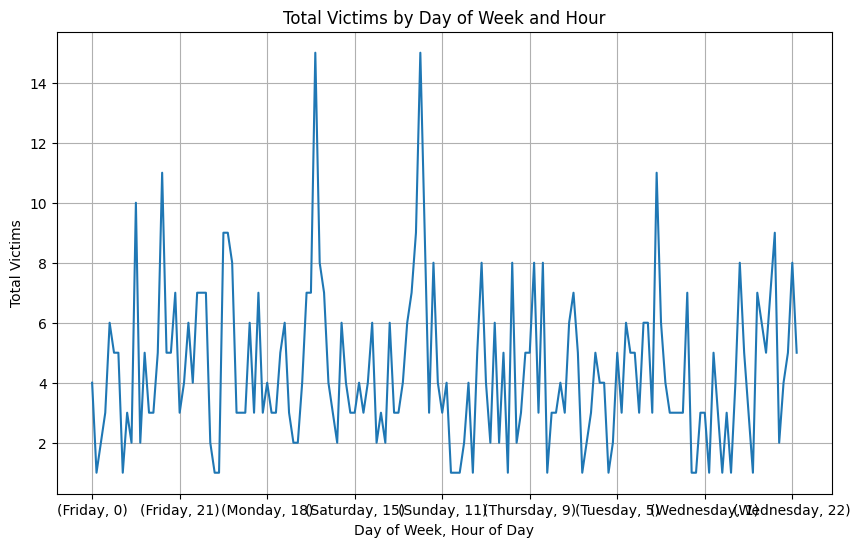

In [85]:
import matplotlib.pyplot as plt

# Assuming data_hm['fecha_hora'] is already a datetime column in data_hm

# Group by day name and hour, then sum 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum()

# Plot the result
grouped_data.plot(kind='line', figsize=(10, 6))
plt.xlabel('Day of Week, Hour of Day')
plt.ylabel('Total Victims')
plt.title('Total Victims by Day of Week and Hour')
plt.grid(True)
plt.show()


In [86]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Hour_of_Day', y='n_victimas', color='Day_of_Week', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [87]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Day_of_Week', y='n_victimas', color='Hour_of_Day', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Day_of_Week': 'Day of Week', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [88]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Iterate over unique days and create a separate bar plot for each day
for day in grouped_data['Day_of_Week'].unique():
    # Filter data for the current day
    day_data = grouped_data[grouped_data['Day_of_Week'] == day]
    
    # Create a bar plot for the current day
    fig = px.bar(day_data, x='Hour_of_Day', y='n_victimas', 
                 title=f'Total Number of Victims by Hour on {day}',
                 labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'})
    
    # Show the plot
    fig.show()


In [89]:
data_hm['es_cruce'] = data_hm['es_cruce'].map({False:'Calle', True:'Esquina'})

In [90]:
import plotly.express as px

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a pie chart using Plotly Express
fig = px.pie(grouped_data, values='n_victimas', names='es_cruce', 
             title='Proportion of Victims by Crossing Status')

# Show the plot
fig.show()

In [91]:
data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()['es_cruce'].map({False:"Calle", True:"Esquina"})

0    NaN
1    NaN
Name: es_cruce, dtype: object

In [92]:
import pandas as pd

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a mapping dictionary
mapping = {False: "Calle", True: "Esquina"}

# Map boolean values to corresponding labels
grouped_data['es_cruce'] = grouped_data['es_cruce'].map(mapping)

# Show the result
print(grouped_data)

  es_cruce  n_victimas
0      NaN         175
1      NaN         540


In [93]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                 data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Año', y='n_victimas', color='Mes',
             title='Total Number of Victims by Day of Year and Month',)
            #  labels={'Año': 'Day of Week', 'n_victimas': 'Total Victims'},
            #  category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()

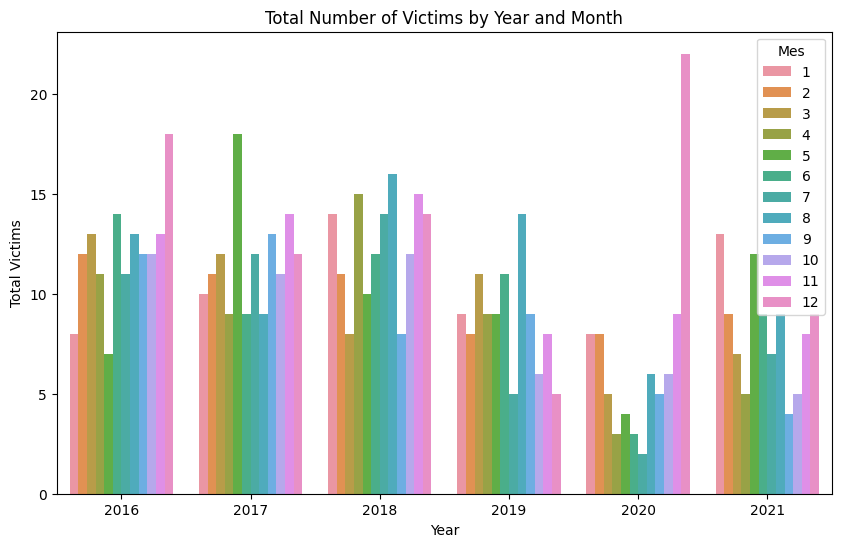

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by year and month, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='Año', y='n_victimas', hue='Mes')

# Set plot title and labels
plt.title('Total Number of Victims by Year and Month')
plt.xlabel('Year')
plt.ylabel('Total Victims')

# Show the plot
plt.show()


In [95]:
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

grouped_data

,Año,Mes,n_victimas
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [96]:
data_hm.groupby(data_hm['fecha_hora'].dt.to_period('M'))['n_victimas'].sum()

fecha_hora
2016-01     8
2016-02    12
2016-03    13
2016-04    11
2016-05     7
           ..
2021-08     9
2021-09     4
2021-10     5
2021-11     8
2021-12     9
Freq: M, Name: n_victimas, Length: 72, dtype: int64

In [97]:
data_hm['fecha_hora'].dt.to_period('M')

ID
2016-0001    2016-01
2016-0002    2016-01
2016-0003    2016-01
2016-0004    2016-01
2016-0005    2016-01
              ...   
2021-0093    2021-12
2021-0094    2021-12
2021-0095    2021-12
2021-0096    2021-12
2021-0097    2021-11
Name: fecha_hora, Length: 694, dtype: period[M]

In [98]:
import plotly.express as px

# Group data by month, summing 'n_victimas'
grouped_data = data_hm.groupby(data_hm['fecha_hora'].dt.to_period('Y'))['n_victimas'].sum().reset_index()

# Convert Period objects to strings
grouped_data['fecha_hora'] = grouped_data['fecha_hora'].astype(str)

# Create a line plot using Plotly Express
fig = px.line(grouped_data, x='fecha_hora', y='n_victimas', 
              title='Total Number of Victims Over Time',
              labels={'fecha_hora': 'Month', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()


In [99]:
# data_hm.to_excel('data/generated/data_hm.xlsx')

In [100]:
data_hm.pos_y.mean()

-34.12078961688012

In [101]:
import folium
from branca.colormap import LinearColormap

# Assuming data contains latitude, longitude, and the value you want to use for color
# Replace 'value_column' with the actual name of the column in your DataFrame
value_column = 'comuna'

data_hm[value_column] = pd.to_numeric(data_hm[value_column], errors='coerce')

data_hm = data_hm.dropna()
data_hm = data_hm.rename({'pos_x': 'lon',  'pos_y': 'lat'}, axis=1)

# Define the minimum and maximum values for the color scale
min_value = data_hm[value_column].astype(float).min()
max_value = data_hm[value_column].astype(float).max()

# Create a color gradient
colormap = LinearColormap(['blue', 'yellow', 'red'], vmin=min_value, vmax=max_value)

# Create a Folium Map
map = folium.Map()

# Iterate over DataFrame rows
for i, row in data_hm.iterrows():
    # Get latitude, longitude, and value
    lat = row['lat']
    lon = row['lon']
    value = row[value_column]
    
    # Get marker color based on the value
    color = colormap(value)
    
    # Create marker with the specified color
    folium.Marker(location=(lat, lon), icon=folium.Icon(color=color)).add_to(map)

# Display the map
# map

In [102]:
import csv

data_hm.to_csv('data/generated/data_hm.csv', sep=';', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8')

In [103]:
data = pd.read_csv('data/generated/data_hm.csv', sep=';', encoding='utf-8')

In [104]:
data.iloc[136]

ID                                         2016-0172
n_victimas                                         1
tipo_de_calle                                AVENIDA
calle                             GARAY, JUAN DE AV.
altura                                           ESQ
cruce                                         CASTRO
dirección_normalizada    GARAY, JUAN DE AV. y CASTRO
comuna                                             5
lon                                       -58.419189
lat                                       -34.631743
participantes                            MOTO-CARGAS
victima                                         MOTO
acusado                                       CARGAS
geo_info                                        True
fecha_hora                       2016-12-26 08:00:00
es_cruce                                     Esquina
Name: 136, dtype: object

In [105]:
# data_hm.to_excel('data/generated/data_hm.xlsx', engine='openpyxl')

In [106]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 2016-0001 to 2021-0097
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   n_victimas             694 non-null    int64         
 1   tipo_de_calle          694 non-null    object        
 2   calle                  694 non-null    object        
 3   altura                 694 non-null    object        
 4   cruce                  694 non-null    object        
 5   dirección_normalizada  694 non-null    object        
 6   comuna                 694 non-null    int64         
 7   lon                    694 non-null    float64       
 8   lat                    694 non-null    float64       
 9   participantes          694 non-null    object        
 10  victima                694 non-null    object        
 11  acusado                694 non-null    object        
 12  geo_info               694 non-null    bool          
 

In [107]:
data_dias = data_hm.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias})

In [108]:
data_dias = data.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

In [109]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

,fecha_hora,n_victimas
0,0,103
1,1,96
2,2,97
3,3,94
4,4,95
5,5,102
6,6,97


In [110]:
data_dias = data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias},
             orientation='h')

fig.show()

In [111]:
data.query('fecha_hora.dt.month == 12 and fecha_hora.dt.year == 2020').n_victimas.sum()

22

In [112]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

datos = data.groupby([data['fecha_hora'].dt.year, data['fecha_hora'].dt.month//6 + 1, data['fecha_hora'].dt.month])['n_victimas'].sum()

datos = datos.rename_axis(['Year', 'Semester', 'Month'])

datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Month' as a string
datos['date'] = datos['Year'].astype(str) + '-' + datos['Month'].astype(str).str.zfill(2)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Month and Year',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'},
             color='n_victimas')

# Show the plot
fig.show()

# datos.head(50)

In [113]:
datos = data.groupby([data['fecha_hora'].dt.year, (data['fecha_hora'].dt.month - 1) // 6 + 1])['n_victimas'].sum()

# Rename the MultiIndex
datos = datos.rename_axis(['Year', 'Semester'])

# Reset the index
datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Semester' as a string
datos['date'] = datos['Year'].astype(str) + '-Semester ' + datos['Semester'].astype(str)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Year and Semester',
             color='n_victimas',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()

In [114]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,lon,lat,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,Esquina
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,Esquina
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,Calle
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,Esquina
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,Esquina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,Esquina
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,Esquina
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,Esquina


### 1.1.2.2 Dataset Lesiones

#### 1.1.2.1.0 Primer Vistazo al Set de Datos

In [115]:
data_hl.replace('SD', np.nan, inplace=True)
resumen(data_hl, "Lesiones")

<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>Lesiones</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> 23785 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> 28 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> 665980 </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> 188194 </td><td style='text-align: right'> 28.26 % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> 0 </td><td style='text-align: right'> 0.0 %</td><tr/>
    </tbody>
    </table>

#### 1.1.2.1.1 Análisis de Nulos

##### a. Por filas

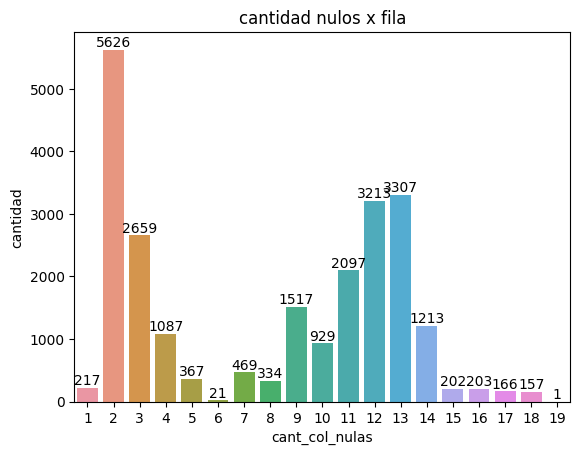

In [116]:
ax = sns.barplot(x=nulos_filas(data_hl).cant_col_nulas, y=nulos_filas(data_hl).cantidad)
for i in ax.containers:
    ax.bar_label(i,)
plt.title("cantidad nulos x fila")
plt.show()

Significa que hay 287 filas que tienen una columna nula, 7437 filas con 2 columnas nula. Este análisis sirve para detectar filas completamente nulas, por ejemplo.

Ahora analizamos los valores nulos por columna.

##### b. Por columnas

In [117]:
data_hl.drop('Unnamed: 0', axis=1, inplace=True, errors='ignore')
data_hl.drop('geocodificacion_CABA', axis=1, inplace=True, errors='ignore')

Dividimos el dataset en 2 para trabajar mejor con los gráficos

In [118]:
data_1 = data_hl.iloc[:, :int(data_hl.shape[1]/2)]

data_2 = data_hl.iloc[:,int(data_hl.shape[1]/2)+1:]

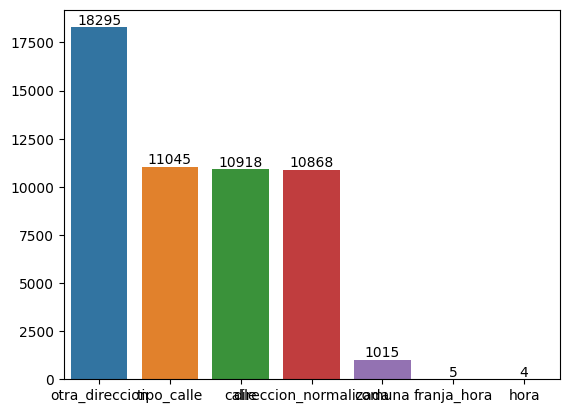

In [119]:
nulos_columnas = data_1.isna().sum()[data_1.isna().sum() > 0].sort_values(ascending=False)
ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

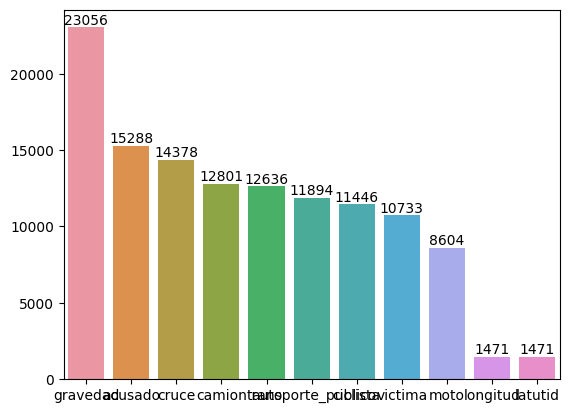

In [120]:
nulos_columnas = data_2.isna().sum()[data_2.isna().sum() > 0].sort_values(ascending=False)
ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [121]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo

print(f"Cantidad filas: {data_hl.shape[0]}")
print(f"Cantidad filas al menos un nulo: {len(data_hl.isna().T.sum()>0)}")

Cantidad filas: 23785
Cantidad filas al menos un nulo: 23785


Debido a la gran cantidad de nulos, y viendo un panorama del dataset, vamos a hacer un recorte de las columnas más útiles a criterio del analista

In [122]:
columnas_conservar = ['id', 'n_victimas', 'fecha', 'hora', 'comuna','longitud', 'latutid', 'victima', 'gravedad']
data_hl[columnas_conservar]

,id,n_victimas,fecha,hora,comuna,longitud,latutid,victima,gravedad
0,LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,14,-58.408911,-34.559658,CICLISTA,NaN
1,LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,8,-58.44351,-34.669125,AUTO,NaN
2,LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,8,-58.468335,-34.677556,NaN,NaN
3,LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,7,-58.437425,-34.647349,PEATON,NaN
4,LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,3,-58.398225,-34.604579,AUTO,NaN
...,...,...,...,...,...,...,...,...,...
23780,LC-2021-0652849,1,2021-12-31 00:00:00,19:30:00,9,-58.513477158887,-34.659713573880,NaN,NaN
23781,LC-2021-0652865,2,2021-12-31 00:00:00,19:40:00,9,-58.488326609395,-34.641753304864,NaN,NaN
23782,LC-2021-0652907,1,2021-12-31 00:00:00,20:00:00,1,-58.382894,-34.583083,NaN,NaN
23783,LC-2021-0652921,1,2021-12-31 00:00:00,22:00:00,5,-58.414532050899,-34.614288229345,MOTO,GRAVE


In [123]:
data_adicional = data_hl[['id','moto', 'auto', 'transporte_publico', 'camion', 'ciclista']]

data_adicional['involucrado'] = data_adicional.eq('x').idxmax(axis=1).str.upper()
data_adicional['involucrado'] = data_adicional['involucrado'].apply(lambda x: 'SD' if x == 'ID' else x)
# data_adicional['involucrado'].fillna('SD', inplace=True)
# pd.merge(data_hl, data_adicional)
data_adicional['involucrado']

0                  CICLISTA
1                      AUTO
2                        SD
3                      MOTO
4        TRANSPORTE_PUBLICO
                ...        
23780                    SD
23781                    SD
23782                    SD
23783                  MOTO
23784                  MOTO
Name: involucrado, Length: 23785, dtype: object

In [124]:
data_adicional = data_hl[['id','moto', 'auto', 'transporte_publico', 'camion', 'ciclista']]

data_adicional['involucrado'] = data_adicional.eq('x').idxmax(axis=1).str.upper()
data_adicional['involucrado'] = data_adicional['involucrado'].apply(lambda x: 'SD' if x == 'ID' else x)

data_hl2 = pd.merge(data_hl,data_adicional, on='id')

In [125]:
data_hl2.dropna(subset=['comuna'], inplace=True)

data_hl2.drop(['transporte_publico_x',	'camion_x',	'ciclista_x','moto_y','auto_y','transporte_publico_y','camion_y','ciclista_y'], axis=1)

,id,n_victimas,aaaa,mm,dd,fecha,hora,franja_hora,direccion_normalizada,comuna,...,cruce,longitud,latutid,victima,acusado,participantes,moto_x,auto_x,gravedad,involucrado
0,LC-2019-0000179,1,2019,1,1,2019-01-01 00:00:00,09:00:00,9,NaN,14,...,NaN,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA-SD,NaN,NaN,NaN,CICLISTA
1,LC-2019-0000053,1,2019,1,1,2019-01-01 00:00:00,01:55:00,1,NaN,8,...,NaN,-58.44351,-34.669125,AUTO,NaN,AUTO-SD,NaN,x,NaN,AUTO
2,LC-2019-0000063,1,2019,1,1,2019-01-01 00:00:00,02:00:00,2,NaN,8,...,NaN,-58.468335,-34.677556,NaN,NaN,SD-SD,NaN,NaN,NaN,SD
3,LC-2019-0000079,1,2019,1,1,2019-01-01 00:00:00,02:30:00,2,NaN,7,...,NaN,-58.437425,-34.647349,PEATON,NaN,PEATON-SD,x,NaN,NaN,MOTO
4,LC-2019-0000082,4,2019,1,1,2019-01-01 00:00:00,04:30:00,4,NaN,3,...,NaN,-58.398225,-34.604579,AUTO,NaN,AUTO-SD,NaN,NaN,NaN,TRANSPORTE_PUBLICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23779,LC-2021-0652812,1,2021,12,31,2021-12-31 00:00:00,18:05:00,18,VIEL 276,6,...,NaN,-58.432885960226,-34.619702288565,NaN,NaN,SD-SD,NaN,NaN,NaN,SD
23780,LC-2021-0652849,1,2021,12,31,2021-12-31 00:00:00,19:30:00,19,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,...,GUAMINI,-58.513477158887,-34.659713573880,NaN,NaN,SD-SD,NaN,NaN,NaN,SD
23781,LC-2021-0652865,2,2021,12,31,2021-12-31 00:00:00,19:40:00,19,"ALBERDI, JUAN BAUTISTA AV. 4436",9,...,NaN,-58.488326609395,-34.641753304864,NaN,NaN,SD-SD,NaN,NaN,NaN,SD
23782,LC-2021-0652907,1,2021,12,31,2021-12-31 00:00:00,20:00:00,20,NaN,1,...,NaN,-58.382894,-34.583083,NaN,NaN,SD-SD,NaN,NaN,NaN,SD


Vemos que todas las filas tienen al menos un valor nulo.

##### c. Nulos Reales y Estructurales

Después de hacer un oversight sobre el dataset, vemos que Altura y Cruce son excluyentes, cuando está definida la altura es porque es sobre una calle propia y en caso contrario es una esquina. Por lo tanto, vamos a excluirlas del análisis de nulos.

In [126]:
data_hl.altura

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
          ...  
23780       0.0
23781    4436.0
23782       NaN
23783       0.0
23784       0.0
Name: altura, Length: 23785, dtype: float64

In [127]:
# La columna altura se llena con ESQ cuando es esquina
data_hl.altura = data_hl.altura.fillna('ESQ')

# Se limpia el valor altura cuando lo toma como decimal
data_hl.altura = data_hl.altura.apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))

In [128]:
data_hl.altura

0         ESQ
1         ESQ
2         ESQ
3         ESQ
4         ESQ
         ... 
23780       0
23781    4436
23782     ESQ
23783       0
23784       0
Name: altura, Length: 23785, dtype: object

In [129]:
data_hl.cruce

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
23780    GUAMINI
23781        NaN
23782        NaN
23783     MORENO
23784        NaN
Name: cruce, Length: 23785, dtype: object

In [130]:
# La columna Cruce se llena con 'NA': 'No Aplica'
data_hl.cruce = data_hl.cruce.fillna('NA')

Ya limpio de los nulos estructurales o sea, definidos por la naturaleza de los campos, vamos a los nulos reales.

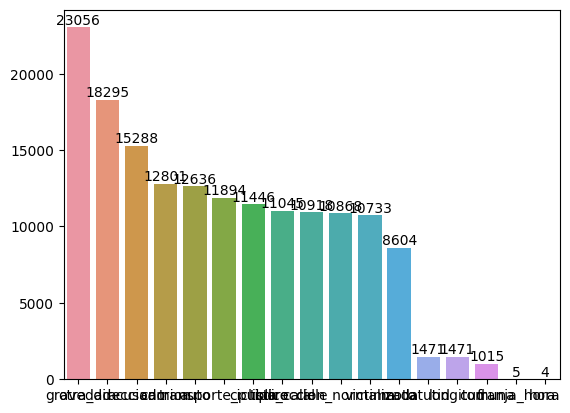

In [131]:
nulos_columnas = data_hl.isna().sum()[data_hl.isna().sum() > 0].sort_values(ascending=False)

if len(nulos_columnas) > 0:
    ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [132]:
data_hl.calle

0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                    ...            
23780    ALBERDI, JUAN BAUTISTA AV.
23781    ALBERDI, JUAN BAUTISTA AV.
23782                           NaN
23783                LINIERS VIRREY
23784                           NaN
Name: calle, Length: 23785, dtype: object

Columna ```Dirección Normalizada```

In [133]:
data_hm[data_hm.isna().loc[:, 'Dirección Normalizada']].head(3)

KeyError: 'Dirección Normalizada'

Columna ```Calle```

In [ ]:
data_hm[data_hm.isna().loc[:, 'Calle']]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,ESQ,NA,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


Al no tener información suficiente podemos excluir el registro ```2016-0151```. Falleció un peatón, sé a qué fecha-hora, pero no sé en dónde, ni cómo.

In [ ]:
data_hm = data_hm.drop(data_hm[data_hm['ID']=='2016-0151'].index)

Rellenamos la información faltante en la columna ```Dirección Normalizada``` con los valores de ```LUGAR_DEL_HECHO```

In [ ]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]
for i in nulos:
    data_hm['Dirección Normalizada'].iloc[i] = data_hm['LUGAR_DEL_HECHO'].iloc[i]

Según lo visto, cuando la direcciòn normalizada es nula es porque ocurre en autopista, sólo un caso en el que es calle porque es un registro con valores nulos o sin datos, del que se puede prescindir.

Vemos que hay otros valores nulos encubiertos, como ```'.'``` en las coordenadas GPS, o ```Point (. .)```, en las otras coordenads espaciales, o ```SD``` en otros campos. Inclusive ```0``` en la columna ```COMUNA```, siendo 15 comunas a partir de la 1.

In [ ]:
data_hm['geo_info'] = True

In [ ]:
# data_['pos x'].apply(lambda x: float(x) if x.lstrip().isnumeric() else None)
data_hm['pos x'] = data_hm['pos x'].apply(lambda x: 0 if x == '.' else float(x))
data_hm['pos y'] = data_hm['pos y'].apply(lambda x: 0 if x == '.' else float(x))


In [ ]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 0 to 695
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     695 non-null    object        
 1   N_VICTIMAS             695 non-null    int64         
 2   FECHA                  695 non-null    datetime64[ns]
 3   AAAA                   695 non-null    int64         
 4   MM                     695 non-null    int64         
 5   DD                     695 non-null    int64         
 6   HORA                   695 non-null    object        
 7   HH                     695 non-null    object        
 8   LUGAR_DEL_HECHO        695 non-null    object        
 9   TIPO_DE_CALLE          695 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 695 non-null    object        
 12  Cruce                  695 non-null    object        
 13  Dirección 

In [ ]:
for i in data_hm.index:
    if data_hm.loc[i, 'pos x'] == 0:
        data_hm.loc[i, 'geo_info'] = False
    if data_hm.loc[i, 'pos y'] == 0:
        data_hm.loc[i, 'geo_info'] = False


In [ ]:
data_hm['geo_info'].value_counts()

geo_info
True     684
False     11
Name: count, dtype: int64

In [ ]:
# data_['pos x'].fillna(data_['pos x'].mean(), inplace=True)
# data_['pos y'].fillna(data_['pos y'].mean(), inplace=True)
# data_hm[data_hm['pos x'].isna()]
# data_hm.query("PARTICIPANTES == 'SD-SD'")
data_hm.query("COMUNA == 0")
# data_hm.COMUNA.isnull().sum()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info
139,2016-0174,1,2016-12-27,2016,12,27,00:00:00,0,AUTOPISTA 25 DE MAYO,AUTOPISTA,...,NA,AUTOPISTA 25 DE MAYO,0,Point (. .),0.0,0.0,SD-SD,SD,SD,False


Eliminada por falta de datos

In [ ]:
data_hm.drop(139, axis =0, inplace = True)

In [ ]:
contar_nulos(data_hm)

ID                       0
N_VICTIMAS               0
FECHA                    0
AAAA                     0
MM                       0
DD                       0
HORA                     0
HH                       0
LUGAR_DEL_HECHO          0
TIPO_DE_CALLE            0
Calle                    0
Altura                   0
Cruce                    0
Dirección Normalizada    0
COMUNA                   0
XY (CABA)                0
pos x                    0
pos y                    0
PARTICIPANTES            0
VICTIMA                  0
ACUSADO                  0
geo_info                 0
dtype: int64

Podemos prescindir de las columnas ```AAAA, MM, DD, HH, XY (CABA)``` ya que duplican información

In [ ]:
data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

In [ ]:
data_hm.COMUNA = data_hm.COMUNA.astype(str)

In [ ]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info
518,2019-0103,1,2019-12-18,SD,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,"PAZ, GRAL. AV.",ESQ,GRIVEO,"PAZ, GRAL. AV. y GRIVEO",11,-58.521694,-34.594716,MOTO-MOTO,MOTO,MOTO,True


In [ ]:
data_hm["HORA"] = data_hm["HORA"].replace('SD', '00:00:00')

In [ ]:
data_hm["HORA"] = data_hm["HORA"].astype(str)

In [ ]:
data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)


In [ ]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info


In [ ]:
# data_hm['COMUNA'] = data_hm['COMUNA'].replace('0', np.nan)

data_hm.COMUNA.isna().sum()

0

In [ ]:
# data_hm['FECHA_HORA'] = pd.to_datetime(data_hm['FECHA']) + data_hm['HORA'].apply(lambda x: pd.Timedelta(x))

In [ ]:
data_hm['HORA'] = data_hm['HORA'].astype(str)

In [ ]:
import re

pattern = r'[:\s;-]'

data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: re.split(pattern, x))

# data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: x.split(' ').split('-').split(':'))


In [ ]:
data_hm['FECHA_HORA']

0      [2016, 01, 01, 04, 00, 00]
1      [2016, 01, 02, 01, 15, 00]
2      [2016, 01, 03, 07, 00, 00]
3      [2016, 01, 10, 00, 00, 00]
4      [2016, 01, 21, 05, 20, 00]
                  ...            
691    [2021, 12, 13, 17, 10, 00]
692    [2021, 12, 20, 01, 10, 00]
693    [2021, 12, 30, 00, 43, 00]
694    [2021, 12, 15, 10, 30, 00]
695    [2021, 11, 18, 06, 10, 00]
Name: FECHA_HORA, Length: 694, dtype: object

In [ ]:
# for i in data_hm['FECHA_HORA']:
#     list(map(int, i))

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(lambda x: list(map(int, x)))

In [ ]:
from datetime import datetime
# # data_hm['FECHA_HORA'].apply(lambda t: datetime(*map(int,t)))

# for i, f in enumerate(data_hm['FECHA_HORA']):
#     for n in f:
#         n = int(n)
#     data_hm['FECHA_HORA'].loc[i] = f

def to_date(t):
    return datetime(* t)

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(to_date)

In [ ]:
data_hm['FECHA_HORA'] 

0     2016-01-01 04:00:00
1     2016-01-02 01:15:00
2     2016-01-03 07:00:00
3     2016-01-10 00:00:00
4     2016-01-21 05:20:00
              ...        
691   2021-12-13 17:10:00
692   2021-12-20 01:10:00
693   2021-12-30 00:43:00
694   2021-12-15 10:30:00
695   2021-11-18 06:10:00
Name: FECHA_HORA, Length: 694, dtype: datetime64[ns]

In [ ]:
# def to_timestamp(x):
#     year, month, day, hour, minute, second = map(int, x)
#     return datetime(year, month, day, hour, minute, second)

In [ ]:
# to_timestamp(data_hm['FECHA_HORA'][0])

In [ ]:
# data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)

In [ ]:
# for i in data_hm['FECHA_HORA'].index:
#     try:
#         to_timestamp(data_hm['FECHA_HORA'].loc[i])
#     except:
#         print(data_hm[['FECHA', 'HORA']].loc[i])


In [ ]:
# date_time_list = [int(x) for x in data_hm['FECHA_HORA'][0]]
# date_time_list

In [ ]:
# year, month, day, hour, minutes, seconds 

In [ ]:
data_hm.COMUNA.value_counts()

COMUNA
1     90
4     76
9     73
8     65
7     60
3     45
15    44
13    40
12    37
14    35
11    32
10    29
2     25
5     22
6     21
Name: count, dtype: int64

In [ ]:
type(data_hm['PARTICIPANTES'][0])

str

In [ ]:
# import json
coordinates = [data_hm['pos x'].sample(1).values[0], data_hm['pos y'].sample(2).values[0]]

# Create a GeoJSON point feature
point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)}
} for x, y, p, d in zip(data_hm['pos x'].values, data_hm['pos y'].values, data_hm['PARTICIPANTES'].values, data_hm['Dirección Normalizada'].values)]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

# pd.DataFrame(point_geojson)

json_file_path = "data/generated/output.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

In [ ]:
data_hm[data_hm['geo_info']]['pos x'].mean()

-58.441545233561044

In [ ]:
data_hm[data_hm['geo_info']]['pos y'].mean()

-34.61963157034327

In [ ]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]



In [ ]:
# data_.iloc[data_['Dirección Normalizada'].isna(), 13] = data_.iloc[data_['Dirección Normalizada'].isna(), 8].values

In [ ]:

data = data_hm.set_index(data_hm.ID)
data.drop('ID', axis=1, inplace=True,errors='ignore')
data

,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info,FECHA_HORA
ID,,,,,,,,,,,,,,,,,
2016-0001,1,2016-01-01,04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00
2016-0002,1,2016-01-02,01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00
2016-0003,1,2016-01-03,07:00:00,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00
2016-0004,1,2016-01-10,00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00
2016-0005,1,2016-01-21,05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,2021-12-13,17:10:00,AV. RIESTRA Y MOM,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00
2021-0094,1,2021-12-20,01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00
2021-0095,1,2021-12-30,00:43:00,AV. GAONA Y TERRADA,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00


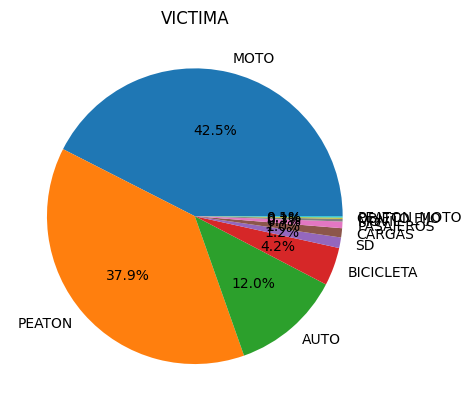

In [ ]:
showPie(data['VICTIMA'])

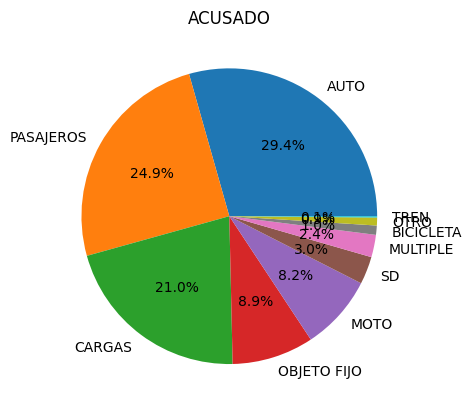

In [ ]:
showPie(data['ACUSADO'])

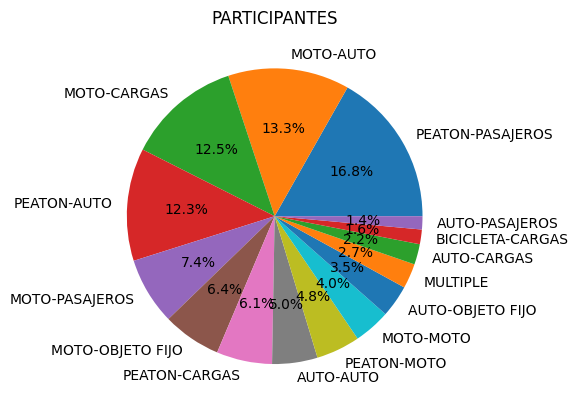

In [ ]:
showPie(data['PARTICIPANTES'])

In [ ]:
data.describe()

,N_VICTIMAS,FECHA,pos x,pos y,FECHA_HORA
count,694.000000,694,694.000000,694.000000,694
mean,1.030259,2018-09-16 01:52:02.766570496,-57.599448,-34.120790,2018-09-16 13:52:40.442363136
min,1.000000,2016-01-01 00:00:00,-58.529942,-34.705250,2016-01-01 04:00:00
25%,1.000000,2017-04-04 18:00:00,-58.475701,-34.643537,2017-04-05 13:41:15
50%,1.000000,2018-07-14 12:00:00,-58.443654,-34.622535,2018-07-14 18:47:00
75%,1.000000,2020-01-04 18:00:00,-58.399650,-34.595143,2020-01-05 11:40:00
max,3.000000,2021-12-30 00:00:00,0.000000,0.000000,2021-12-30 00:43:00
std,0.179644,NaN,6.969679,4.128761,NaN


In [ ]:
# data['ACUSADO'].corr(data['VICTIMA'])

48

In [ ]:


comunas['barrios'] = comunas.BARRIOS.apply(lambda x: x.split(' - '))

# pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas[['ID', 'COMUNAS']], left_on='comuna_id', right_on='ID')
comunas.set_index('COMUNAS', drop=True, inplace=True)
comunas.drop('ID', axis = 1, inplace=True, errors='ignore')
comunas.sort_index()

,OBJETO,BARRIOS,PERIMETRO,AREA,barrios
COMUNAS,,,,,
1,LIMITE COMUNAL,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,"[CONSTITUCION, MONTSERRAT, PUERTO MADERO, RETI..."
2,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
3,LIMITE COMUNAL,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,"[BALVANERA, SAN CRISTOBAL]"
4,LIMITE COMUNAL,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,35423.282799,2.168464e+07,"[BARRACAS, BOCA, NUEVA POMPEYA, PARQUE PATRICIOS]"
5,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
6,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
7,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
8,LIMITE COMUNAL,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,20935.012513,2.221690e+07,"[VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI]"
9,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"


In [ ]:
pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas, left_on='comuna_id', right_on='COMUNAS')

,comuna_id,barrios_x,OBJETO,BARRIOS,PERIMETRO,AREA,barrios_y
0,2,RECOLETA,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
1,5,ALMAGRO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
2,5,BOEDO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
3,6,CABALLITO,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
4,7,FLORES,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
5,7,PARQUE CHACABUCO,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
6,9,LINIERS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
7,9,MATADEROS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
8,9,PARQUE AVELLANEDA,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
9,10,FLORESTA,LIMITE COMUNAL,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"[FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS..."


In [ ]:
barrio_comuna = pd.DataFrame(comunas.barrios.explode())

In [ ]:
comunas

,OBJETO,BARRIOS,PERIMETRO,AREA,barrios
COMUNAS,,,,,
2,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
5,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
6,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
7,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
9,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
10,LIMITE COMUNAL,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"[FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS..."
11,LIMITE COMUNAL,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,"[VILLA DEL PARQUE, VILLA DEVOTO, VILLA GRAL. ..."
12,LIMITE COMUNAL,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,"[COGHLAN, SAAVEDRA, VILLA PUEYRREDON, VILLA UR..."
14,LIMITE COMUNAL,PALERMO,22126.531858,1.584587e+07,[PALERMO]


In [ ]:
# barrios.BARRIO.

In [ ]:
# import pandas as pd
# import researchpy as rp

# # Assuming df is your DataFrame containing the categorical variables
# # Let's say 'var1' and 'var2' are the columns representing the categorical variables

# data = data.reset_index()

# # Create a contingency table (cross-tabulation)
# contingency_table = pd.crosstab(data['ACUSADO'], data['VICTIMA'])

# # Calculate Cramér's V
# cramers_v_result = rp.crosstab(data['ACUSADO'], data['VICTIMA'], 
#                                 prop= 'cell', 
#                                 test= 'chi-square', 
#                                 expected_freqs= True, 
                                
#                                 correction= False)['results']

# cramers_v = cramers_v_result.loc[2, 'results']

# print("Cramér's V:", cramers_v)


In [ ]:
# %pip install ipywidgets

In [ ]:
pd.crosstab(data_hm['VICTIMA'], data_hm['ACUSADO'])


ACUSADO,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
VICTIMA,,,,,,,,,,
AUTO,31,0,14,0,3,21,1,9,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,83,2,78,25,8,40,4,46,9,0
MOVIL,0,0,1,0,0,0,0,1,0,0
OBJETO FIJO,1,0,0,0,0,0,0,0,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,77,5,38,30,5,0,0,105,3,0
PEATON_MOTO,0,0,0,1,0,0,0,0,0,0


In [ ]:
data_hm['ES_CRUCE'] = data_hm['Cruce'] != 'NA'

In [ ]:
data_hm['ES_CRUCE'].value_counts()

ES_CRUCE
True     525
False    169
Name: count, dtype: int64

In [ ]:
data_hm['Cruce'].fillna('NA', inplace=True)

In [ ]:
pd.crosstab(data_hm['PARTICIPANTES'], data_hm['ES_CRUCE']).sum()

ES_CRUCE
False    169
True     525
dtype: int64

In [ ]:
data_hm = data_hm.set_index(data_hm['ID']).drop(['ID','FECHA','HORA','LUGAR_DEL_HECHO'], axis=1)

In [ ]:
data_hm.columns = [c.lower().replace(' ','_') for c in data_hm.columns]

# plt.plot(data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum())

In [ ]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


In [ ]:
data_hm['comuna'][data_hm['comuna'].isnull()]

Series([], Name: comuna, dtype: object)

In [ ]:
data_hm['comuna'] = data_hm['comuna'].apply(lambda x: int(x))

In [ ]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


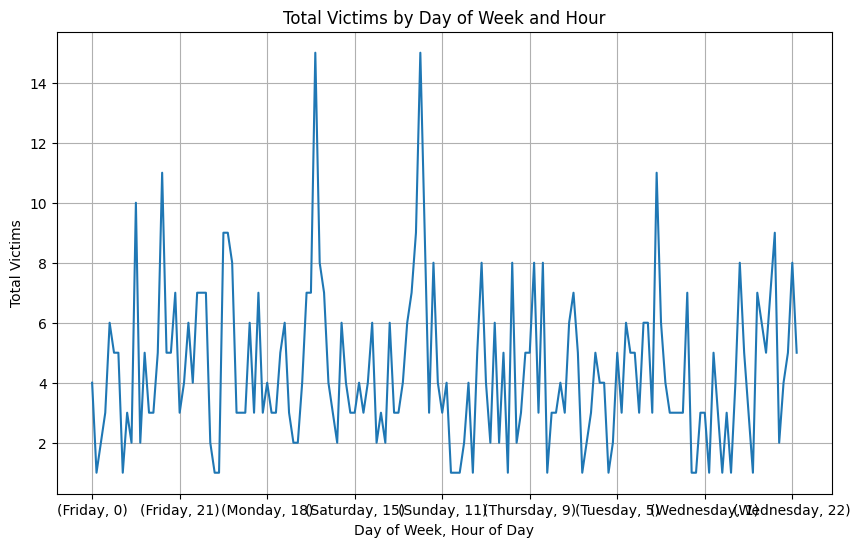

In [ ]:
import matplotlib.pyplot as plt

# Assuming data_hm['fecha_hora'] is already a datetime column in data_hm

# Group by day name and hour, then sum 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum()

# Plot the result
grouped_data.plot(kind='line', figsize=(10, 6))
plt.xlabel('Day of Week, Hour of Day')
plt.ylabel('Total Victims')
plt.title('Total Victims by Day of Week and Hour')
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Hour_of_Day', y='n_victimas', color='Day_of_Week', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Day_of_Week', y='n_victimas', color='Hour_of_Day', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Day_of_Week': 'Day of Week', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Iterate over unique days and create a separate bar plot for each day
for day in grouped_data['Day_of_Week'].unique():
    # Filter data for the current day
    day_data = grouped_data[grouped_data['Day_of_Week'] == day]
    
    # Create a bar plot for the current day
    fig = px.bar(day_data, x='Hour_of_Day', y='n_victimas', 
                 title=f'Total Number of Victims by Hour on {day}',
                 labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'})
    
    # Show the plot
    fig.show()


In [ ]:
data_hm['es_cruce'] = data_hm['es_cruce'].map({False:'Calle', True:'Esquina'})

In [ ]:
import plotly.express as px

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a pie chart using Plotly Express
fig = px.pie(grouped_data, values='n_victimas', names='es_cruce', 
             title='Proportion of Victims by Crossing Status')

# Show the plot
fig.show()

In [ ]:
data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()['es_cruce'].map({False:"Calle", True:"Esquina"})

0    NaN
1    NaN
Name: es_cruce, dtype: object

In [ ]:
import pandas as pd

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a mapping dictionary
mapping = {False: "Calle", True: "Esquina"}

# Map boolean values to corresponding labels
grouped_data['es_cruce'] = grouped_data['es_cruce'].map(mapping)

# Show the result
print(grouped_data)

  es_cruce  n_victimas
0      NaN         175
1      NaN         540


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                 data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Año', y='n_victimas', color='Mes',
             title='Total Number of Victims by Day of Year and Month',)
            #  labels={'Año': 'Day of Week', 'n_victimas': 'Total Victims'},
            #  category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()

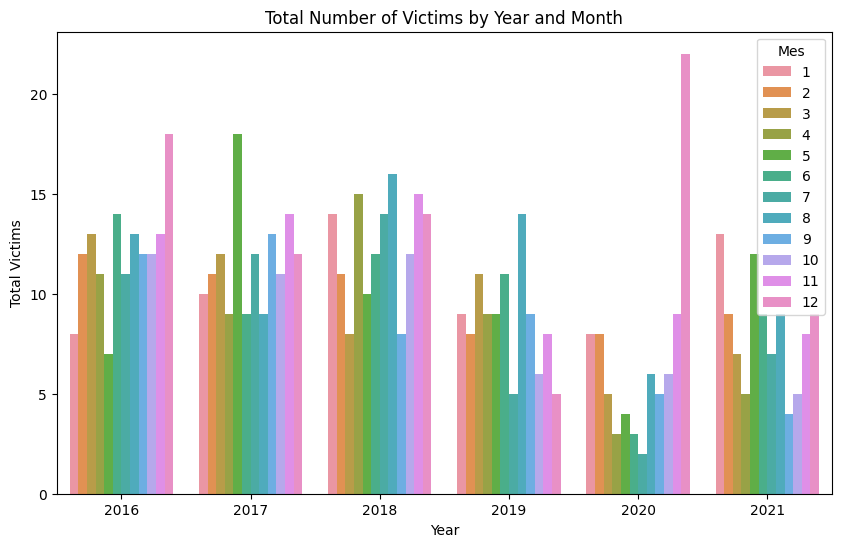

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by year and month, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='Año', y='n_victimas', hue='Mes')

# Set plot title and labels
plt.title('Total Number of Victims by Year and Month')
plt.xlabel('Year')
plt.ylabel('Total Victims')

# Show the plot
plt.show()


In [ ]:
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

grouped_data

,Año,Mes,n_victimas
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [ ]:
data_hm.groupby(data_hm['fecha_hora'].dt.to_period('M'))['n_victimas'].sum()

fecha_hora
2016-01     8
2016-02    12
2016-03    13
2016-04    11
2016-05     7
           ..
2021-08     9
2021-09     4
2021-10     5
2021-11     8
2021-12     9
Freq: M, Name: n_victimas, Length: 72, dtype: int64

In [ ]:
data_hm['fecha_hora'].dt.to_period('M')

ID
2016-0001    2016-01
2016-0002    2016-01
2016-0003    2016-01
2016-0004    2016-01
2016-0005    2016-01
              ...   
2021-0093    2021-12
2021-0094    2021-12
2021-0095    2021-12
2021-0096    2021-12
2021-0097    2021-11
Name: fecha_hora, Length: 694, dtype: period[M]

In [ ]:
import plotly.express as px

# Group data by month, summing 'n_victimas'
grouped_data = data_hm.groupby(data_hm['fecha_hora'].dt.to_period('Y'))['n_victimas'].sum().reset_index()

# Convert Period objects to strings
grouped_data['fecha_hora'] = grouped_data['fecha_hora'].astype(str)

# Create a line plot using Plotly Express
fig = px.line(grouped_data, x='fecha_hora', y='n_victimas', 
              title='Total Number of Victims Over Time',
              labels={'fecha_hora': 'Month', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()


In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx')

In [ ]:
data_hm.pos_y.mean()

-34.12078961688012

In [ ]:
import folium
from branca.colormap import LinearColormap

# Assuming data contains latitude, longitude, and the value you want to use for color
# Replace 'value_column' with the actual name of the column in your DataFrame
value_column = 'comuna'

data_hm[value_column] = pd.to_numeric(data_hm[value_column], errors='coerce')

data_hm = data_hm.dropna()
data_hm = data_hm.rename({'pos_x': 'lon',  'pos_y': 'lat'}, axis=1)

# Define the minimum and maximum values for the color scale
min_value = data_hm[value_column].astype(float).min()
max_value = data_hm[value_column].astype(float).max()

# Create a color gradient
colormap = LinearColormap(['blue', 'yellow', 'red'], vmin=min_value, vmax=max_value)

# Create a Folium Map
map = folium.Map()

# Iterate over DataFrame rows
for i, row in data_hm.iterrows():
    # Get latitude, longitude, and value
    lat = row['lat']
    lon = row['lon']
    value = row[value_column]
    
    # Get marker color based on the value
    color = colormap(value)
    
    # Create marker with the specified color
    folium.Marker(location=(lat, lon), icon=folium.Icon(color=color)).add_to(map)

# Display the map
# map

In [ ]:
import csv

data_hm.to_csv('data/generated/data_hm.csv', sep=';', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8')

In [ ]:
data = pd.read_csv('data/generated/data_hm.csv', sep=';', encoding='utf-8')

In [ ]:
data.iloc[136]

ID                                         2016-0172
n_victimas                                         1
tipo_de_calle                                AVENIDA
calle                             GARAY, JUAN DE AV.
altura                                           ESQ
cruce                                         CASTRO
dirección_normalizada    GARAY, JUAN DE AV. y CASTRO
comuna                                             5
lon                                       -58.419189
lat                                       -34.631743
participantes                            MOTO-CARGAS
victima                                         MOTO
acusado                                       CARGAS
geo_info                                        True
fecha_hora                       2016-12-26 08:00:00
es_cruce                                     Esquina
Name: 136, dtype: object

In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx', engine='openpyxl')

In [ ]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 2016-0001 to 2021-0097
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   n_victimas             694 non-null    int64         
 1   tipo_de_calle          694 non-null    object        
 2   calle                  694 non-null    object        
 3   altura                 694 non-null    object        
 4   cruce                  694 non-null    object        
 5   dirección_normalizada  694 non-null    object        
 6   comuna                 694 non-null    int64         
 7   lon                    694 non-null    float64       
 8   lat                    694 non-null    float64       
 9   participantes          694 non-null    object        
 10  victima                694 non-null    object        
 11  acusado                694 non-null    object        
 12  geo_info               694 non-null    bool          
 

In [ ]:
data_dias = data_hm.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias})

In [ ]:
data_dias = data.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

In [ ]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

,fecha_hora,n_victimas
0,0,103
1,1,96
2,2,97
3,3,94
4,4,95
5,5,102
6,6,97


In [ ]:
data_dias = data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias},
             orientation='h')

fig.show()

In [ ]:
data.query('fecha_hora.dt.month == 12 and fecha_hora.dt.year == 2020').n_victimas.sum()

22

In [ ]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

datos = data.groupby([data['fecha_hora'].dt.year, data['fecha_hora'].dt.month//6 + 1, data['fecha_hora'].dt.month])['n_victimas'].sum()

datos = datos.rename_axis(['Year', 'Semester', 'Month'])

datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Month' as a string
datos['date'] = datos['Year'].astype(str) + '-' + datos['Month'].astype(str).str.zfill(2)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Month and Year',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'},
             color='n_victimas')

# Show the plot
fig.show()

# datos.head(50)

In [ ]:
datos = data.groupby([data['fecha_hora'].dt.year, (data['fecha_hora'].dt.month - 1) // 6 + 1])['n_victimas'].sum()

# Rename the MultiIndex
datos = datos.rename_axis(['Year', 'Semester'])

# Reset the index
datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Semester' as a string
datos['date'] = datos['Year'].astype(str) + '-Semester ' + datos['Semester'].astype(str)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Year and Semester',
             color='n_victimas',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()

In [ ]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,lon,lat,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,Esquina
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,Esquina
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,Calle
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,Esquina
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,Esquina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,Esquina
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,Esquina
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,Esquina


# EDA

In [ ]:
showPiePx(data_hm.n_victimas)

In [ ]:

# sns.catplot(x="tipo_de_calle", data = data_hm['tipo_de_calle', 'n_victimas'].groupby("tipo_de_calle").sum(), kind='box')

In [ ]:
showPiePx(data_hm.tipo_de_calle)


In [ ]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 2016-0001 to 2021-0097
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   n_victimas             694 non-null    int64         
 1   tipo_de_calle          694 non-null    object        
 2   calle                  694 non-null    object        
 3   altura                 694 non-null    object        
 4   cruce                  694 non-null    object        
 5   dirección_normalizada  694 non-null    object        
 6   comuna                 694 non-null    int64         
 7   lon                    694 non-null    float64       
 8   lat                    694 non-null    float64       
 9   participantes          694 non-null    object        
 10  victima                694 non-null    object        
 11  acusado                694 non-null    object        
 12  geo_info               694 non-null    bool          
 

In [ ]:
showPiePx(data_hm.es_cruce)

In [ ]:
showPiePx(data_hm.comuna)

In [ ]:
showPiePx(data_hm.participantes)

In [ ]:
showPiePx(data_hm.victima)

In [ ]:
showPiePx(data_hm.acusado)

In [ ]:
# pd.concat(data_hm.query("tipo_de_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'], data_hm.query("tipo_de_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'], axis=1)

In [ ]:
import pandas as pd

autopista_counts = data_hm.query("tipo_de_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas']
avenida_counts = data_hm.query("tipo_de_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas']

concatenated_counts = pd.concat([autopista_counts, avenida_counts], axis=1)


In [ ]:
import pandas as pd

# Calculate total occurrences for each type of street
total_autopista = data_hm.query("tipo_de_calle == 'AUTOPISTA'")['n_victimas'].count()
total_avenida = data_hm.query("tipo_de_calle == 'AVENIDA'")['n_victimas'].count()

# Calculate frequencies
autopista_counts = data_hm.query("tipo_de_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'] / total_autopista
autopista_counts.name = 'AUTOPISTA Frequency'

avenida_counts = data_hm.query("tipo_de_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'] / total_avenida
avenida_counts.name = 'AVENIDA Frequency'

# Concatenate into a DataFrame
concatenated_frequencies = pd.concat([autopista_counts, avenida_counts], axis=1)


In [ ]:
data_hm.tipo_de_calle.value_counts()

tipo_de_calle
AVENIDA      429
CALLE        135
GRAL PAZ      65
AUTOPISTA     65
Name: count, dtype: int64

In [ ]:
pd.DataFrame([data_hm.query(f"tipo_de_calle == '{st}'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'].rename(f"{st}") for st in data_hm.tipo_de_calle.unique()]).T

,AVENIDA,GRAL PAZ,CALLE,AUTOPISTA
fecha_hora,,,,
0,67,11,15,13
1,58,6,25,9
2,62,9,18,9
3,62,5,18,9
4,65,6,20,5
5,59,12,23,9
6,56,16,16,11


In [ ]:
((data_hm.fecha_hora.dt.month-1) // 6).value_counts()

fecha_hora
1    357
0    337
Name: count, dtype: int64